#  Sélection de variables : une introduction




<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=«python-datascientist»&resources.requests.memory=«4Gi»&security.allowlist.enabled=false&init.personalInit=«https://raw.githubusercontent.com/linogaliana/python-datascientist/master/init_onyxia.sh»)
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=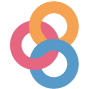)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/4_featureselection.ipynb)

Pour illustrer le travail de données nécessaire pour faire de la sélection de variable,
nous allons partir du même jeu de données que précédemment,
c'est-à-dire les résultats des élections US 2020 présentés dans l'[introduction
de cette partie](https://linogaliana-teaching.netlify.app/modelisation/): les données de vote aux élections présidentielles US
croisées à des variables socio-démographiques.
Le code 
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/course/modelisation/get_data.py).





Jusqu'à présent, nous avons supposé que les variables permettant d'éclairer le
vote Républicain étaient connues. Nous n'avons ainsi exploité qu'une partie
limitée de l'information disponible dans nos données. Néanmoins, outre le fléau
computationnel que représenterait la construction d'un modèle avec un grand
nombre de variables, le choix d'un nombre restreint de variables
(modèle parcimonieux) limite le risque de sur-apprentissage.

Comment, dès-lors, choisir le bon nombre de variables et la meilleure
combinaison de ces variables ? Il existe de multiples méthodes, parmi lesquelles :

* se fonder sur des critères statistiques de performance qui pénalisent les
modèles non parcimonieux. Par exemple, le BIC.
* techniques de *backward elimination*.
* construire des modèles pour lesquels la statistique d'intérêt pénalise l'absence
de parcimonie. 

# Principe du LASSO

## Principe général

La classe des modèles de *feature selection* est ainsi très vaste et regroupe
un ensemble très diverse de modèles. Nous allons nous focaliser sur le LASSO
(*Least Absolute Shrinkage and Selection Operator*)
qui est une extension de la régression linéaire qui vise à sélectionner des
modèles *sparses*. Ce type de modèle est central dans le champ du 
*Compressed sensing* (où on emploie plutôt le terme 
de *L1-regularization* que de LASSO). Le LASSO est un cas particulier des
régressions elastic-net dont un autre cas fameux est la régression *ridge*.
Contrairement à la régression linéaire classique, elles fonctionnent également
dans un cadre où $p>N$, c'est à dire où le nombre de régresseurs est très grand puisque supérieur
au nombre d'observations.

## Pénalisation

En adoptant le principe d'une fonction objectif pénalisée,
le LASSO permet de fixer un certain nombre de coefficients à 0.
Les variables dont la norme est non nulle passent ainsi le test de sélection. 

Le LASSO est un programme d'optimisation sous contrainte. On cherche à trouver l'estimateur $\beta$ qui minimise l'erreur quadratique (régression linéaire) sous une contrainte additionnelle régularisant les paramètres:
$$
\min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) \\
\text{s.t. } \sum_{j=1}^p |\beta_j| \leq t
$$
Ce programme se reformule grâce au Lagrangien est permet ainsi d'obtenir un programme de minimisation plus maniable : 
$$
\beta^{\text{LASSO}} = \arg \min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) + \alpha \sum_{j=1}^p |\beta_j| = \arg \min_{\beta} ||y-X\beta||_{2}^{2} + \alpha ||\beta||_1
$$
où $\lambda$ est une réécriture de la régularisation précédente. 

<!-- warning: sélection de variables corrélées -->

## Première régression LASSO

Avant de se lancer dans les exercices, on va éliminer quelques colonnes redondantes, 
celles qui concernent les votes des parties concurrents (forcément très
corrélés au vote Républicain...)  :


In [ ]:
df2 = votes.loc[:,~votes.columns.str.endswith(('_democrat','_green','_other', 'per_point_diff', 'per_dem'))]

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'votes' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

**Exercice 1 : Premier LASSO**


In [ ]:
# packages utiles
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
import seaborn as sns

1. Préparez les variables à utiliser.
* Ne garder que les colonnes numériques (idéalement on transformerait
les variables non numériques en numériques)
* Remplacer les valeurs infinies par des NaN
* Standardiser les variables avec `StandardScaler`


In [ ]:
#1. Garder uniquement les variables numériques et standardiser.
df2 = votes.loc[:,~votes.columns.str.endswith(('_democrat','_green','_other', 'per_point_diff', 'per_dem'))]

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'votes' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
df2 = df2.select_dtypes(include=np.number)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'df2' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'df2' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
df2 = df2.fillna(0)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'df2' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
col_names = df2.loc[:, df2.columns != 'per_gop'].columns.values

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'df2' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
features = df2[col_names]

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'df2' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
features = StandardScaler().fit(features.values).transform(features.values)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'features' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
df2[col_names] = features
#df2.head()

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'features' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

2. On cherche toujours à prédire la variable `per_gop`. Créez un échantillon d'entraînement et un échantillon test. 


In [ ]:
#2. Echantillon d'entraînement et échantillon test
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["per_gop"], axis = 1),
    100*df2[['per_gop']].values.ravel(), test_size=0.2, random_state=0
)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'df2' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 2, in <module>
```

3. Estimer un modèle LASSO pénalisé avec $alpha = 0.1$. Afficher les valeurs des coefficients. Quelles variables ont une valeur non nulle ?

Les variables sélectionnées sont : 


In [ ]:
#3. Estimer un modèle LASSO et afficher les valeurs des coefficients
lasso1 = Lasso(fit_intercept=True,normalize=False, alpha = 0.1).fit(X_train,y_train)

#np.abs(lasso1.coef_)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
features_selec = df2.select_dtypes(include=np.number).drop("per_gop", axis = 1).columns[np.abs(lasso1.coef_)>0].tolist()

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'df2' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
features_selec
# Le modèle est assez parcimonieux puisque 
# un sous-échantillon de variables sont sélectionnées 

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'features_selec' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

* Certaines variables font sens, comme les variables d'éducation par exemple ;Notamment, un des meilleurs prédicteurs pour le score des Républicains en 2020 est... le score des Républicains (et mécaniquement des démocrates) en 2016.
* On sélectionne des variables redondantes. Une phase plus approfondie de nettoyage des données serait nécessaire ;

4. Montrer que les variables sélectionnées sont parfois très corrélées 


In [ ]:
#4. Corrélations entre les variables sélectionnées
corr = df2[features_selec].corr()

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'df2' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
plt.figure()
p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'corr' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
p

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'p' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
plt.savefig("correlationvar.png")

```r
knitr::include_graphics("correlationvar.png")
```


5. Comparer la performance de ce modèle parcimonieux avec celle d'un modèle avec plus de variables 


In [ ]:
#5. Faire une régression linéaire parcimonieuse et non parcimonieuse

## Régression parcimonieuse
y_pred_parci = lasso1.predict(X_test)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'lasso1' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
rmse_parci = sklearn.metrics.mean_squared_error(y_test, y_pred_parci, squared = False)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_test' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
print("rmse_parci : ", rmse_parci)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'rmse_parci' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
rsq_parci = sklearn.metrics.r2_score(y_test, y_pred_parci) 

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_test' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
print("rsq_parci : ", rsq_parci)

## Régression non parcimonieuse

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'rsq_parci' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
ols = LinearRegression().fit(X_train, y_train)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
y_pred_nonparci = ols.predict(X_test)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'ols' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
rmse_nonparci = sklearn.metrics.mean_squared_error(y_test, y_pred_nonparci, squared = False)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_test' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
print("rmse_nonparci : ", rmse_nonparci)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'rmse_nonparci' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
rsq_nonparci = sklearn.metrics.r2_score(y_test, y_pred_nonparci) 

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_test' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
print("rsq_nonparci : ", rsq_nonparci)

# Le modèle parcimonieux est plus performant. 

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'rsq_nonparci' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```


In [ ]:

### Autres exemples Lino : 
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#print(smf.ols("per_gop ~ share_2016_republican", data = #df2).fit().summary())
# Performance du modèle déjà bonne avec une variable explicative
# Par la suite : se contenter de variables moins bonnes mais qui
# présentent un intérêt pour la sélection
#df2 = votes.loc[:,~votes.columns.str.endswith(("_republican",'_democrat','_green','_other', 'per_point_diff', 'per_dem'))]
# df2 = df[[c for c in df.columns if c not in cols_to_exclude] + ['rep16_frac']]

6. Utiliser la fonction `lasso_path` pour évaluer le nombre de paramètres sélectionnés par LASSO lorsque $\alpha$
varie (parcourir $\alpha \in [0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0]$ ). 


In [ ]:
#6. Utilisation de lasso_path
my_alphas = np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])
alpha_for_path, coefs_lasso, _ = lasso_path(X_train,y_train,alphas=my_alphas)
#print(coefs_lasso)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'X_train' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
nb_non_zero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'coefs_lasso' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
print(nb_non_zero)

## graphique
# Graphe emprunté à http://tutoriels-data-mining.blogspot.com/2018/05/regression-lasso-sous-python.html

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'nb_non_zero' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
sns.set_style("whitegrid")
plt.figure()
p = sns.lineplot(y=nb_non_zero, x=alpha_for_path).set(title = r"Number variables and regularization parameter ($\alpha$)", xlabel=r'$\alpha$', ylabel='Nb. de variables')

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'nb_non_zero' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
p

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'p' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
plt.savefig("lassoplot.png")

```r
knitr::include_graphics("lassoplot.png")
```

On voit que plus alpha est élevé, moins le modèle sélectionne de variables.



## Validation croisée pour sélectionner le modèle

Quel $\alpha$ faut-il privilégier ? Pour cela, 
il convient d'effectuer une validation croisée afin de choisir le modèle pour
lequel les variables qui passent la phase de sélection permettent de mieux
prédire le résultat Républicain.




In [ ]:
print("alpha optimal :", lcv.alpha_)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'lcv' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```



Les variables sélectionnées sont : 


In [ ]:
print(features_selec2)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'features_selec2' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```



In [ ]:
df2.select_dtypes(include=np.number).drop("per_gop", axis = 1).columns[np.abs(lasso2.coef_)>0]

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'df2' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
nlasso = sum(np.abs(lasso2.coef_)>0)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'lasso2' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
print(nlasso)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'nlasso' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'nlasso' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

Dans le cas où le modèle paraîtrait trop peu parcimonieux, il faudrait revoir la phase de définition des variables pertinentes pour comprendre si des échelles différentes de certaines variables ne seraient pas plus appropriées (par exemple du `log`). 